In [216]:
%matplotlib inline
import pandas as pd
import numpy as np
import math
import matplotlib as mpl
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy import optimize
from scipy import stats
import uncertainties as unc
import uncertainties.unumpy as unp


df = pd.read_excel('Raddam_Data.xlsx')
df

,TileName,SampleRun,Size,Dose (Mrad),Duration (day),Comment,DoseRate (rad/h),Dose (Mrad).1,Date,Duration (day).1,...,TestBeamPE,TestBeamPEError,Bi207Trial1PE,Bi207Trial2PE,Bi207Trial3PE,Bi207AveragePE,Trial1PMTCurr,Trial2PMTCurr,Trial3PMTCurr,PMTCurrAverage (nA)
0,BC428 t1,1,7x7,10,NaN,NaN,20800,10,3/18 – 4/11/14,24,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,BC428 t7,2,7x7,10,NaN,NaN,20800,10,3/18 – 4/11/14,24,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,18,6,10x10,0.1,45,NaN,144,0.1,NaN,30,...,48.62,0.50,15.118,15.141,14.991,15.083333,69.360000,69.90,69.38,69.546667
3,19,5,10x10,0.1,3.5,NaN,20800,NaN,NaN,NaN,...,41.54,0.43,15.066,14.895,15.037,14.999333,71.550000,70.19,68.60,70.113333
4,20,8,10x10,0.3,45,NaN,582,0.3,3/18 – 4/9/14,22,...,NaN,NaN,12.591,12.598,12.592,12.593667,57.490000,57.01,58.51,57.670000
5,22,NaN,10x10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,11.780,11.788,11.839,11.802333,52.720000,51.86,53.13,52.570000
6,23,NaN,10x10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,12.992,12.997,12.971,12.986667,65.980000,66.62,64.75,65.783333
7,25,20,10x10,1.7,NaN,NaN,19700,1.7,NaN,NaN,...,NaN,NaN,8.998,9.003,8.988,8.996333,32.210000,31.21,31.11,31.510000
8,29,21,10x10,1.7,NaN,NaN,19700,1.7,NaN,NaN,...,NaN,NaN,8.547,8.539,8.386,8.490667,29.000000,29.46,30.19,29.550000
9,32,NaN,10x10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,15.348,15.326,14.845,15.173000,76.910000,79.88,79.53,78.773333


# Function for Finding D Constant and Uncertainty in D

In [217]:
def Find_D_with_Error(df,dose_rate,PE,err): # put dose_rate in rad/h
    
    if PE == "Bi207AveragePE":
        refPE = np.mean([15.17,15.26,16.06,15.84]) # average of all the PEs for all reference tiles (10x10 and 7x7)
    elif PE == "PMTCurrAverage (nA)":
        refPE = np.mean([78.7733,75.8667,75.48,72.53])
    elif PE == "TestBeamPE":
        refPE = 49.02
    
    dRData = df[df["DoseRate (rad/h)"]==dose_rate]

    dose = np.append(np.array(dRData["Dose (Mrad)"], dtype = float),0) # the 0 point is for the reference
    sourcePE = np.append(np.array(dRData[PE], dtype = float), refPE)
    LL0 = sourcePE/refPE 

    print dRData["Size"]
    
    # assigning uncertainty to L/L0
    if PE == "TestBeamPE":
        tberr = np.array(dRData["TestBeamPEError"], dtype = float)
        tberr = np.append(tberr, 0)
        fracerr = tberr/sourcePE
        yerr = []
        for i in range(len(fracerr)):
            err = LL0[i]*np.sqrt(fracerr[0]**2 + fracerr[i]**2)
            yerr.append(err)
            
    else:
        yerr=np.sqrt(err**2 + err**2)*LL0 # for example 5% of each light yield measurement. Here y is L/L0
    
    yerr[-1] = 1e-10    # this is the uncertainty of the first point. In principle, it should be zero.
                        # for some reason, if the error is zero, the code couldn't estimate the uncertainty for D.

#    for i in range(len(dose)):  # if dose is more than 5 Mrad, assume 500% uncertainty in light yield measurement
#        if dose[i]>5:
#            yerr[i] = np.sqrt(0.05**2 + 2**2)*LL0[i]
    i = 0        
    while i < len(dose):  # if dose is more than 5 Mrad, drop the measurement
        if dose[i]>5:
            yerr = np.delete(yerr,i)
            dose = np.delete(dose,i)
            LL0 = np.delete(LL0,i)
        i+=1
        
    def func(d,mu):
        return np.exp(-d*mu)

    fitres = curve_fit(func, dose, LL0, sigma=yerr, full_output=True, absolute_sigma=True)
    popt=fitres[0][0]
    pcov=np.sqrt(fitres[1][0][0])

    Dcon = 1/popt
    Derr = pcov/(popt**2)
   
    print("The best fit function is L/L_0 = exp{-%4.2f * d}" % (popt))
    print("D constant is %4.2f +- %4.2f." % (Dcon,Derr))    

    ran = np.linspace(np.amin(dose),np.amax(dose),100)
    mpl.rc("font", family="serif", size=16)
    plt.figure(figsize=(15,8))
    plt.plot(ran, func(ran, popt), 'r-')
    #plt.plot(ran,np.exp(-ran*(popt - pcov/(popt**2))),'b-') # shows the range of values for D graphically
    #plt.plot(ran,np.exp(-ran*(popt + pcov/(popt**2))),'g-')
    plt.errorbar(dose, LL0, yerr=yerr, linestyle='None', ecolor='k', marker='o',
    markerfacecolor='black', markersize=5.2, label='Tile',capsize=3)
    plt.ylabel("$L/L_0$")
    plt.xlabel("Dose (Mrad)")
    plt.show()

    return Dcon,dose_rate/1000.,Derr

# Function for Plotting D Constant vs. Dose Rate (with Sigma Bands)

In [218]:
def plot_D_vs_R(doserate, Dconstant, Derror, Setup):
    def func_R(R, a, b):
        return np.sqrt(R)/(a+b*np.sqrt(R))

    fitres = optimize.curve_fit(func_R, doserate, Dconstant, sigma=Derror, p0=[0.21,0.184], 
                                full_output=True, absolute_sigma=True)
    popt=fitres[0]; pcov=fitres[1]
    # Need to use correlated errors to draw sigma bands
    a, b = unc.correlated_values(popt, pcov)
    print('Fit results: \na = {0:.3f} \nb = {1:.3f}'.format(a,b))
    redchisq = (fitres[2]['fvec']**2).sum()/(len(fitres[2]['fvec'])-len(popt))
    print("chi2/Ndof = %6.3f" % redchisq)
    #print len(fitres[2]['fvec'])
    finex=np.arange(min(doserate)*0.9,max(doserate)*1.1,0.01)

    ran = np.linspace(0.00009,101.,10000)
    
    mpl.rc("font", family="serif", size=20)
    plt.figure(figsize=(20,11))
    plt.yscale("log")
    plt.xscale("log")
    plt.ylim([0.009,11.])
    plt.xlim([0.00009,101.])
    py = func_R(finex,a,b)
    nom = unp.nominal_values(py)
    std = unp.std_devs(py)
    plt.plot(ran, np.sqrt(ran)/(0.210 + 0.184*np.sqrt(ran)), 'm-.')
    plt.errorbar(doserate, Dconstant, yerr=Derror, linestyle='None', ecolor='k',fmt='ro',
                label='Tile',capsize=3)
    plt.plot(finex, func_R(finex, *popt), 'b-',linewidth=2,label=r'Fit: $y={0:.2f}x+{1:.2f}$'.format(*popt)) # fit line
    plt.fill_between(finex, nom-1*std, nom+1*std, facecolor='#696969',alpha=0.6,label='1$\sigma$ band of fit') # bands
    plt.fill_between(finex, nom-2*std, nom+2*std, facecolor='#696969',alpha=0.3,label='2$\sigma$ band of fit') # bands
    #plt.plot(0.144, 1.03, 'bo') # N2 source data
    plt.legend(["$D = \\frac{\sqrt{R}}{0.210+0.184\sqrt{R}}$","Best Fit","$\sigma$ from Best Fit",
                "$2\sigma$ from Best Fit","Bi207 with "+Setup+" (Air)"])
    plt.ylabel("Dose Constant (Mrad)")
    plt.xlabel("Dose Rate (krad/h)")
    plt.show()

# Defining different sets of data to work with

In [219]:
# General conditions for every set of data
withDose = df["Dose (Mrad)"].notnull()
withDoseRate = df["DoseRate (rad/h)"].notnull()  # .notnull() gives TRUE for the indices with non-NaN values
withBi207 = df["Bi207AveragePE"].notnull()
withPMT = df["PMTCurrAverage (nA)"].notnull()

# Air data
Air = -df["Comment"].notnull() # air data has no comment in the spreadsheet

Airdf = df[(((Air & withDose) & withDoseRate) & withBi207) & withPMT]

# N2 data
N2 = df["Comment"] == "N2"
N2more = df["Comment"] == "N2; leave in N2 to study annealing" # doesn't actually matter, because dose rates 
                                                               # are missing for data with this comment

N2df = df[((((N2 | N2more) & withDose) & withDoseRate) & withBi207) & withPMT]

# Test beam data
testBeam = df["TestBeamPE"].notnull()

tbdf = df[(((testBeam & withDose) & withDoseRate) & withBi207) & Air] # test beam data only has air data

# SiPM Data

## Air Data

### Dose rate = 19.7 krad/h

7     10x10
8     10x10
27      7x7
28      7x7
29      7x7
30      7x7
Name: Size, dtype: object
The best fit function is L/L_0 = exp{-0.35 * d}
D constant is 2.84 +- 0.15.


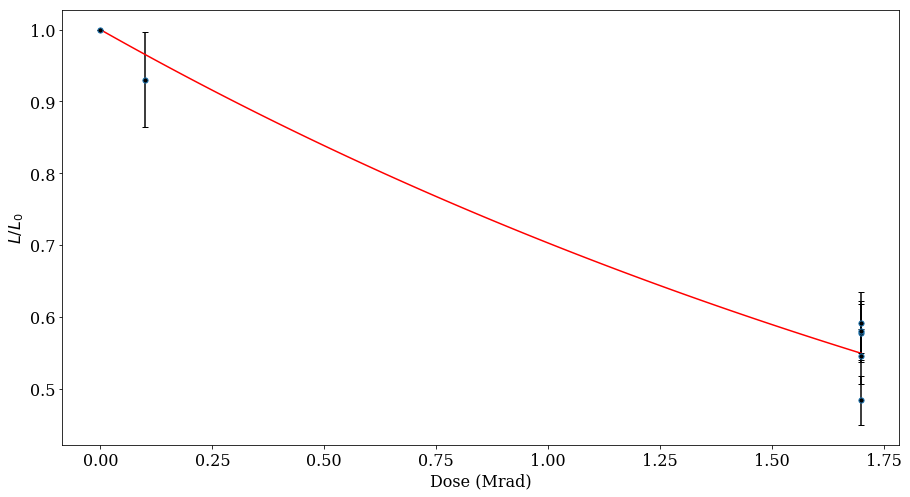

In [220]:
SA_197 = Find_D_with_Error(Airdf,19700,"Bi207AveragePE",0.05)

### Dose rate = 20.8 krad/h

3     10x10
15      7x7
16      7x7
21      7x7
Name: Size, dtype: object
The best fit function is L/L_0 = exp{-0.51 * d}
D constant is 1.97 +- 0.17.


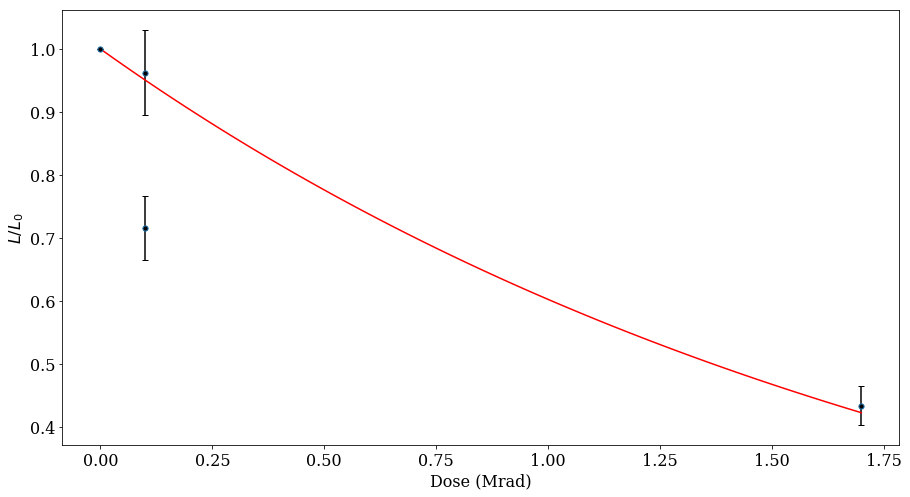

In [221]:
SA_208 = Find_D_with_Error(Airdf,20800,"Bi207AveragePE",0.05)

### Dose Rate = 0.582 krad/h

4     10x10
18      7x7
Name: Size, dtype: object
The best fit function is L/L_0 = exp{-0.55 * d}
D constant is 1.83 +- 0.56.


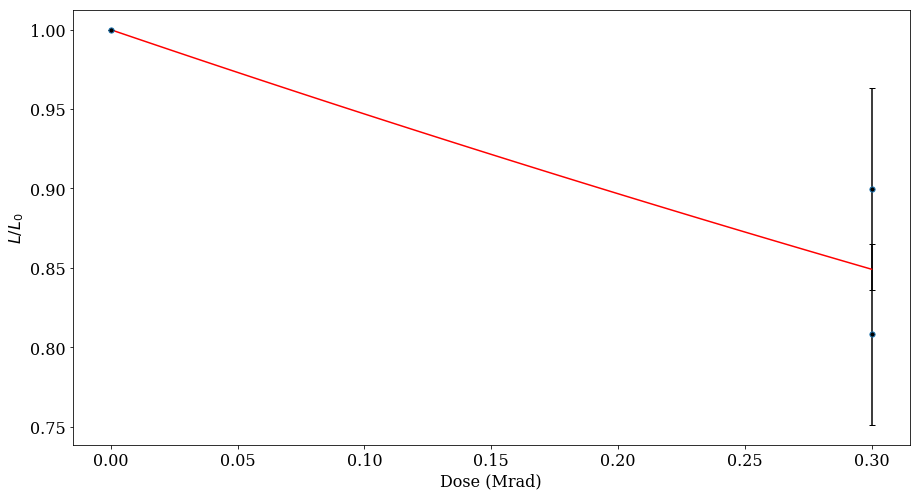

In [222]:
SA_582 = Find_D_with_Error(Airdf,582,"Bi207AveragePE",0.05)

### Dose Rate = 0.144 krad/h

2     10x10
17      7x7
Name: Size, dtype: object
The best fit function is L/L_0 = exp{-1.15 * d}
D constant is 0.87 +- 0.38.


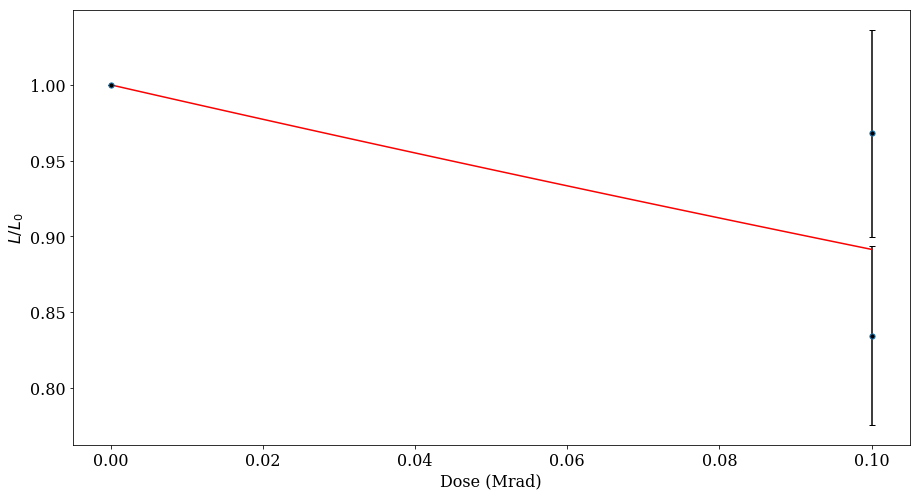

In [223]:
SA_144 = Find_D_with_Error(Airdf,144,"Bi207AveragePE",0.05)

## D Constant vs. Dose Rate (Air Only)

Fit results: 
a = 0.229+/-0.122 
b = 0.358+/-0.034
chi2/Ndof =  7.838


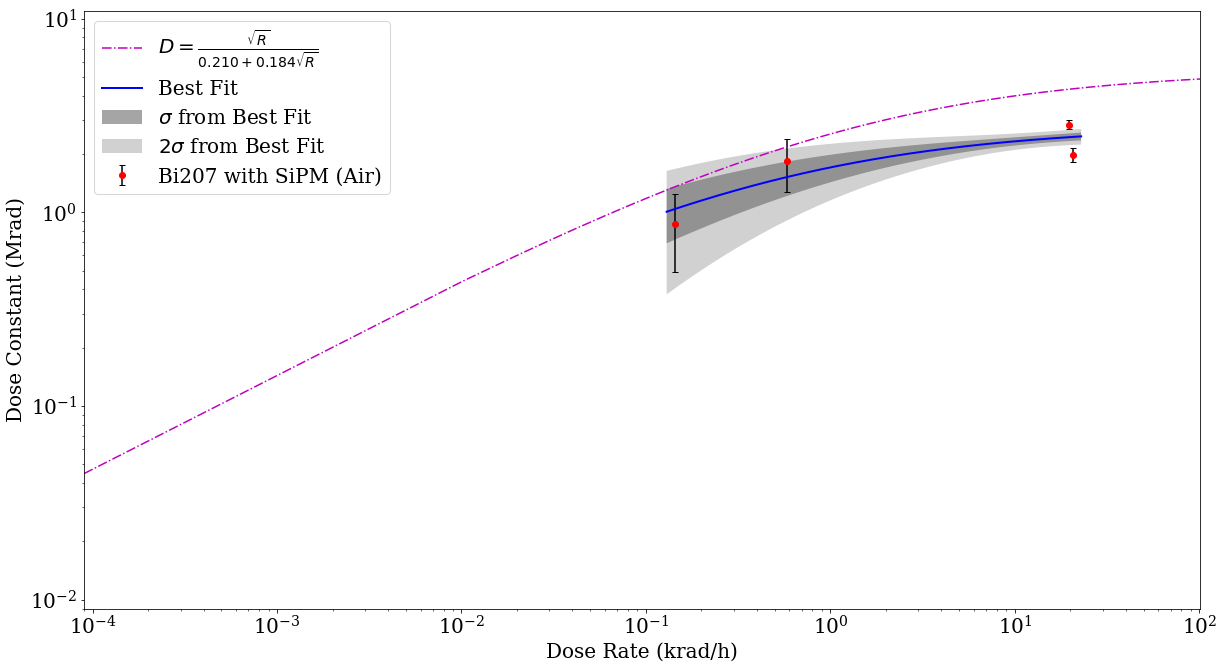

In [224]:
SA_Dconstant = [SA_208[0],SA_197[0],SA_582[0],SA_144[0]]
SA_doserate = [SA_208[1],SA_197[1],SA_582[1],SA_144[1]]
SA_error = [SA_208[2],SA_197[2],SA_582[2],SA_144[2]]

plot_D_vs_R(SA_doserate, SA_Dconstant, SA_error, "SiPM")

## $N_2$ Data

10    10x10
24      7x7
Name: Size, dtype: object
The best fit function is L/L_0 = exp{-0.66 * d}
D constant is 1.51 +- 1.14.


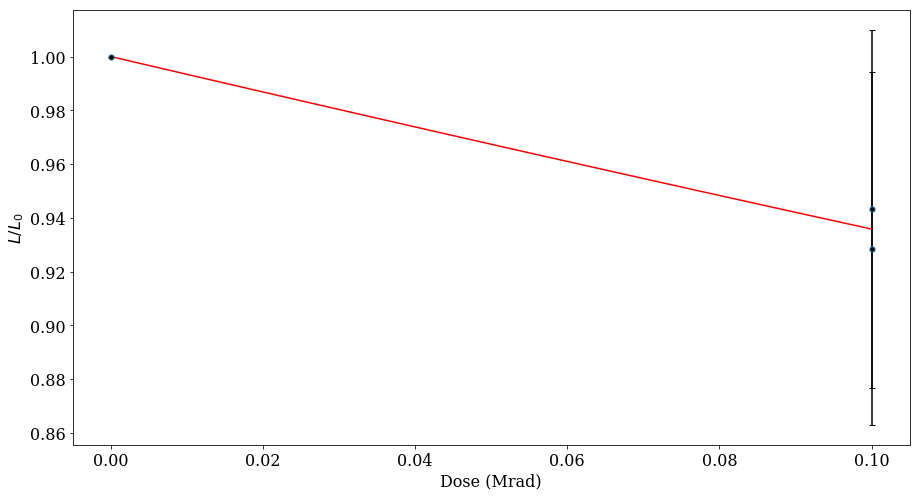

In [225]:
SN_144 = Find_D_with_Error(N2df,144,"Bi207AveragePE",0.05)

## D Constant vs. Dose Rate (Air + $N_2$)

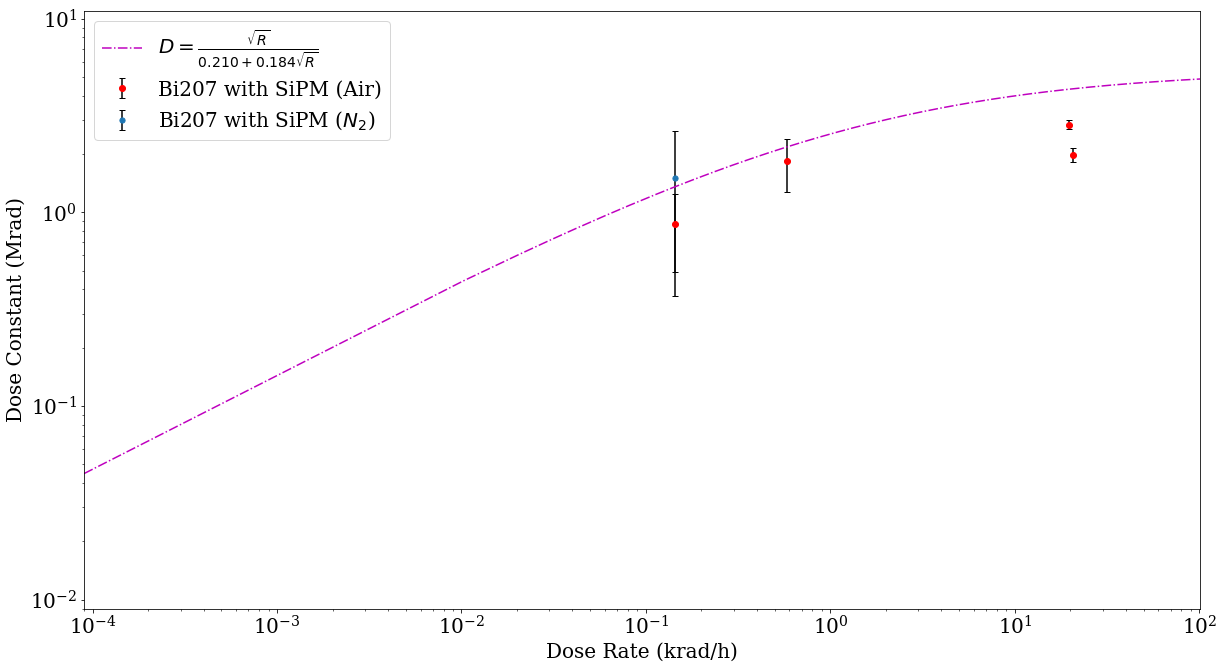

In [226]:
def func_R(R, a, b):
    return np.sqrt(R)/(a+b*np.sqrt(R))

fitres = optimize.curve_fit(func_R, Air_doserate, Air_Dconstant, sigma=Air_error, p0=[0.21,0.184], 
                            full_output=True, absolute_sigma=True)
popt=fitres[0]; pcov=fitres[1]

ran = np.linspace(0.00009,101.,10000)

mpl.rc("font", family="serif", size=20)
plt.figure(figsize=(20,11))
plt.yscale("log")
plt.xscale("log")
plt.ylim([0.009,11.])
plt.xlim([0.00009,101.])

plt.plot(ran, np.sqrt(ran)/(0.210 + 0.184*np.sqrt(ran)), 'm-.')
plt.errorbar(Air_doserate, Air_Dconstant, yerr=Air_error, linestyle='None', ecolor='k',fmt='ro',
            label='Tile',capsize=3)
plt.errorbar(SN_144[1], SN_144[0], yerr=SN_144[2], linestyle='None', ecolor='k', marker='o',
             markersize=5.2, capsize=3) # N2 source data
plt.legend(["$D = \\frac{\sqrt{R}}{0.210+0.184\sqrt{R}}$","Bi207 with SiPM (Air)",
           "Bi207 with SiPM ($N_2$)"])
plt.ylabel("Dose Constant (Mrad)")
plt.xlabel("Dose Rate (krad/h)")
plt.show()

# PMT Data

## Air Data

### Dose rate = 19.7 krad/h

7     10x10
8     10x10
27      7x7
28      7x7
29      7x7
30      7x7
Name: Size, dtype: object
The best fit function is L/L_0 = exp{-0.66 * d}
D constant is 1.51 +- 0.13.


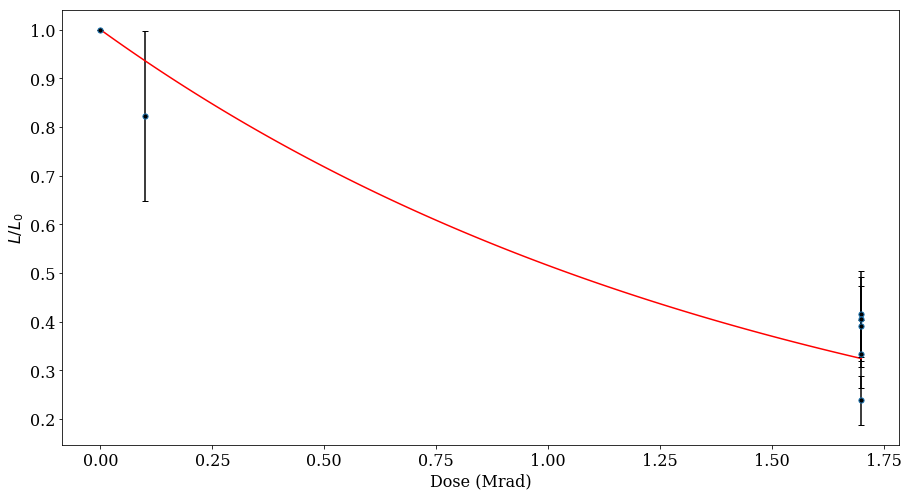

In [227]:
PA_197 = Find_D_with_Error(Airdf,19700,"PMTCurrAverage (nA)",0.15) # assuming each PMT measurement has 15% uncertainty

### Dose rate = 20.8 krad/h

3     10x10
15      7x7
16      7x7
21      7x7
Name: Size, dtype: object
The best fit function is L/L_0 = exp{-0.95 * d}
D constant is 1.05 +- 0.14.


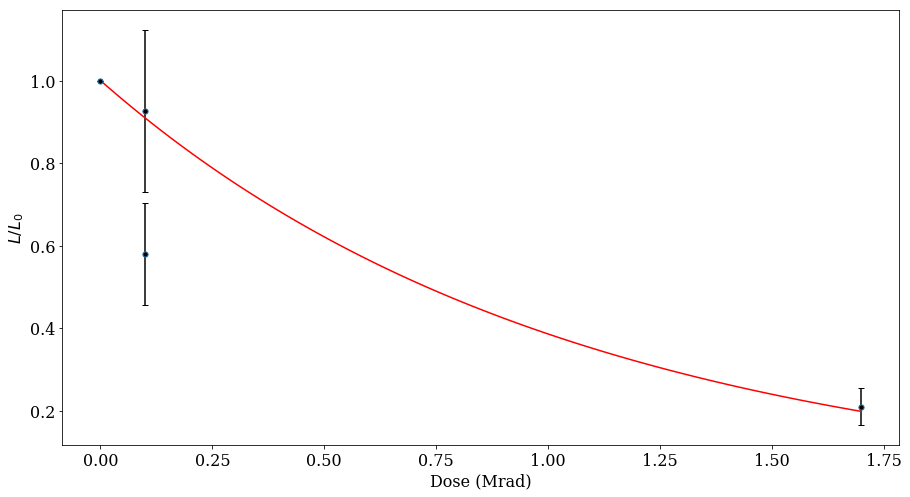

In [228]:
PA_208 = Find_D_with_Error(Airdf,20800,"PMTCurrAverage (nA)",0.15)

### Dose rate = 0.582 krad/h

4     10x10
18      7x7
Name: Size, dtype: object
The best fit function is L/L_0 = exp{-0.79 * d}
D constant is 1.26 +- 0.79.


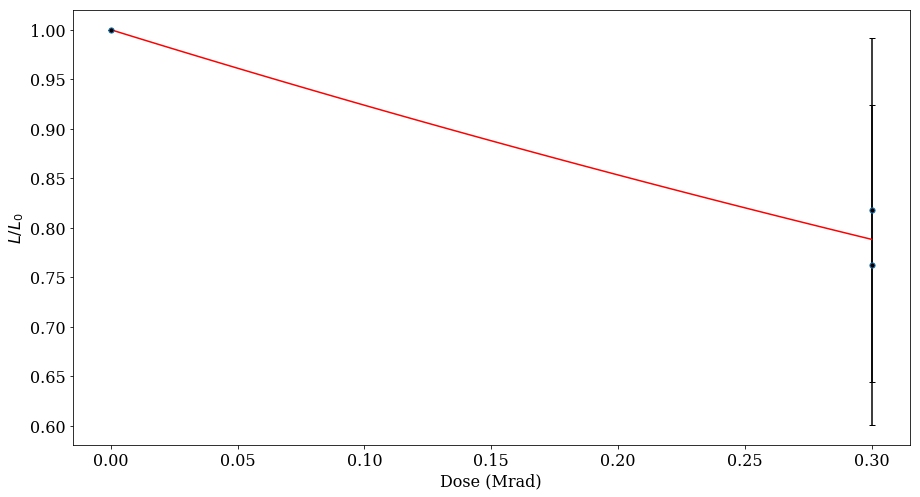

In [229]:
PA_582 = Find_D_with_Error(Airdf,582,"PMTCurrAverage (nA)",0.15)

### Dose rate = 0.144 krad/h

2     10x10
17      7x7
Name: Size, dtype: object
The best fit function is L/L_0 = exp{-1.97 * d}
D constant is 0.51 +- 0.39.


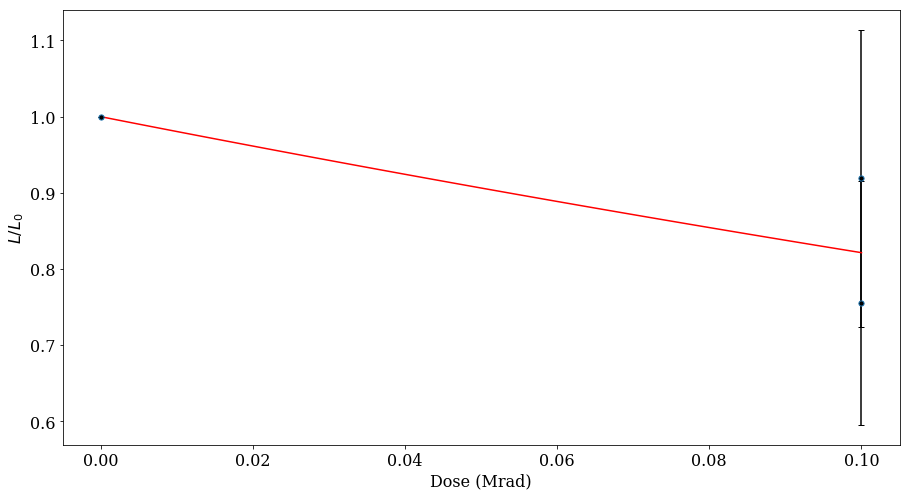

In [230]:
PA_144 = Find_D_with_Error(Airdf,144,"PMTCurrAverage (nA)",0.15)

## D Constant vs. Dose Rate (Air)

Fit results: 
a = 0.357+/-0.393 
b = 0.688+/-0.108
chi2/Ndof =  2.990


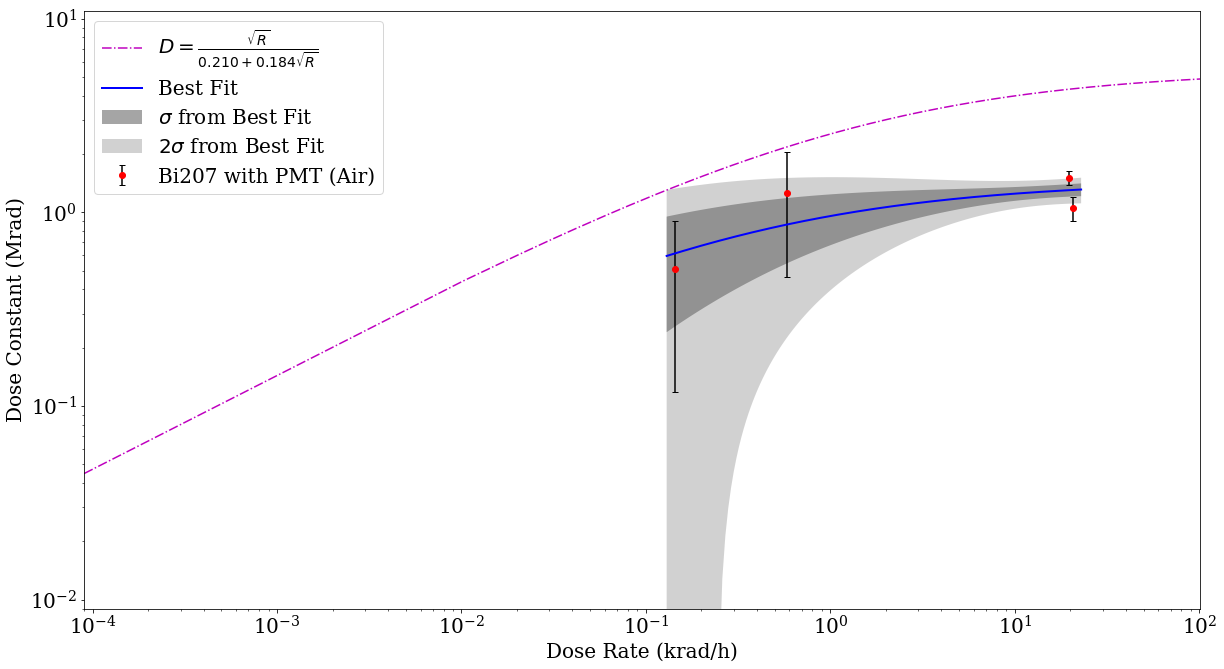

In [231]:
PA_Dconstant = [PA_208[0],PA_197[0],PA_582[0],PA_144[0]]
PA_doserate = [PA_208[1],PA_197[1],PA_582[1],PA_144[1]]
PA_error = [PA_208[2],PA_197[2],PA_582[2],PA_144[2]]

plot_D_vs_R(PA_doserate, PA_Dconstant, PA_error, "PMT")

## $N_2$ Data

10    10x10
24      7x7
Name: Size, dtype: object
The best fit function is L/L_0 = exp{-0.80 * d}
D constant is 1.26 +- 2.37.


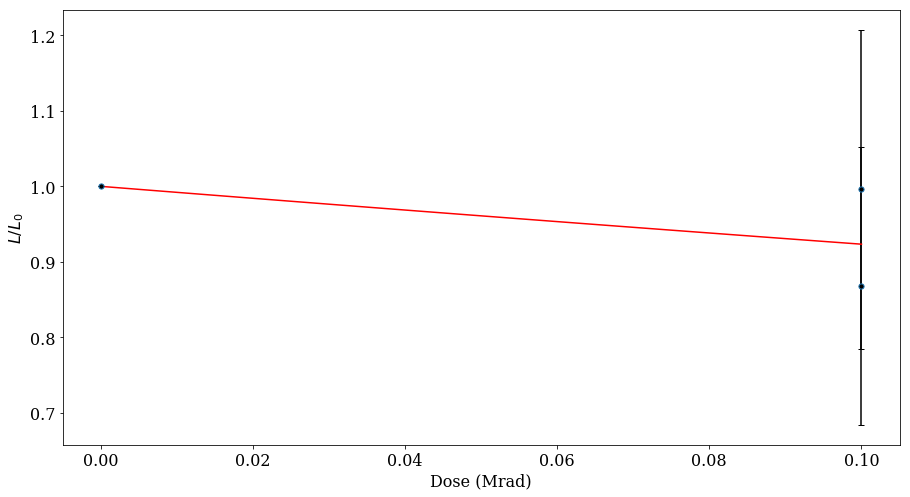

In [232]:
PN_144 = Find_D_with_Error(N2df,144,"PMTCurrAverage (nA)",0.15)

## D Constant vs. Dose Rate ($N_2$)

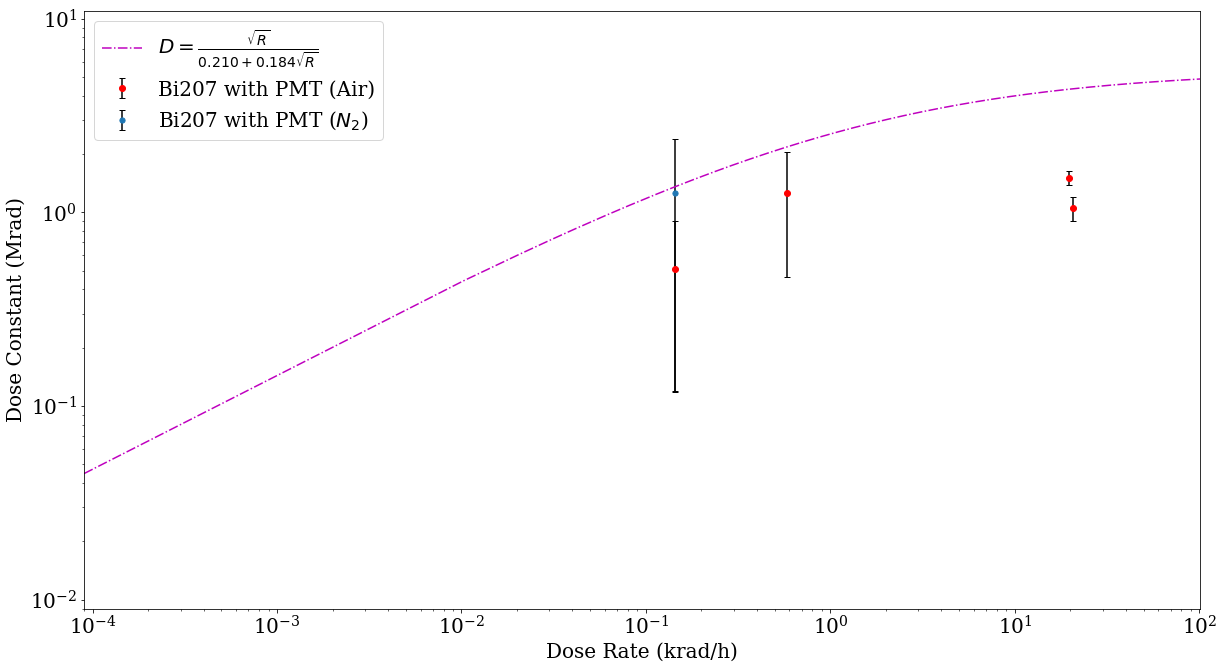

In [233]:
def func_R(R, a, b):
    return np.sqrt(R)/(a+b*np.sqrt(R))

fitres = optimize.curve_fit(func_R, Air_doserate, Air_Dconstant, sigma=Air_error, p0=[0.21,0.184], 
                            full_output=True, absolute_sigma=True)
popt=fitres[0]; pcov=fitres[1]

ran = np.linspace(0.00009,101.,10000)

mpl.rc("font", family="serif", size=20)
plt.figure(figsize=(20,11))
plt.yscale("log")
plt.xscale("log")
plt.ylim([0.009,11.])
plt.xlim([0.00009,101.])

plt.plot(ran, np.sqrt(ran)/(0.210 + 0.184*np.sqrt(ran)), 'm-.')
plt.errorbar(PA_doserate, PA_Dconstant, yerr=PA_error, linestyle='None', ecolor='k',fmt='ro',
            label='Tile',capsize=3)
plt.errorbar(PN_144[1], PN_144[0], yerr=SN_144[2], linestyle='None', ecolor='k', marker='o',
             markersize=5.2, capsize=3) # N2 source data
plt.legend(["$D = \\frac{\sqrt{R}}{0.210+0.184\sqrt{R}}$","Bi207 with PMT (Air)",
           "Bi207 with PMT ($N_2$)"])
plt.ylabel("Dose Constant (Mrad)")
plt.xlabel("Dose Rate (krad/h)")
plt.show()

# Test Beam Data

3     10x10
15      7x7
21      7x7
Name: Size, dtype: object
The best fit function is L/L_0 = exp{-0.92 * d}
D constant is 1.09 +- 0.01.


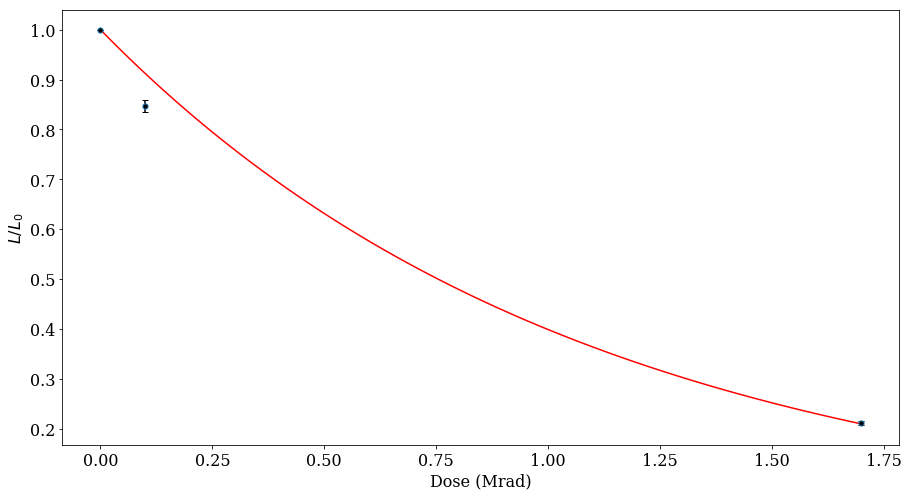

In [239]:
TA_208 = Find_D_with_Error(tbdf,20800,"TestBeamPE",0)

 # Putting Everything Together

## D vs. R with Error Bars

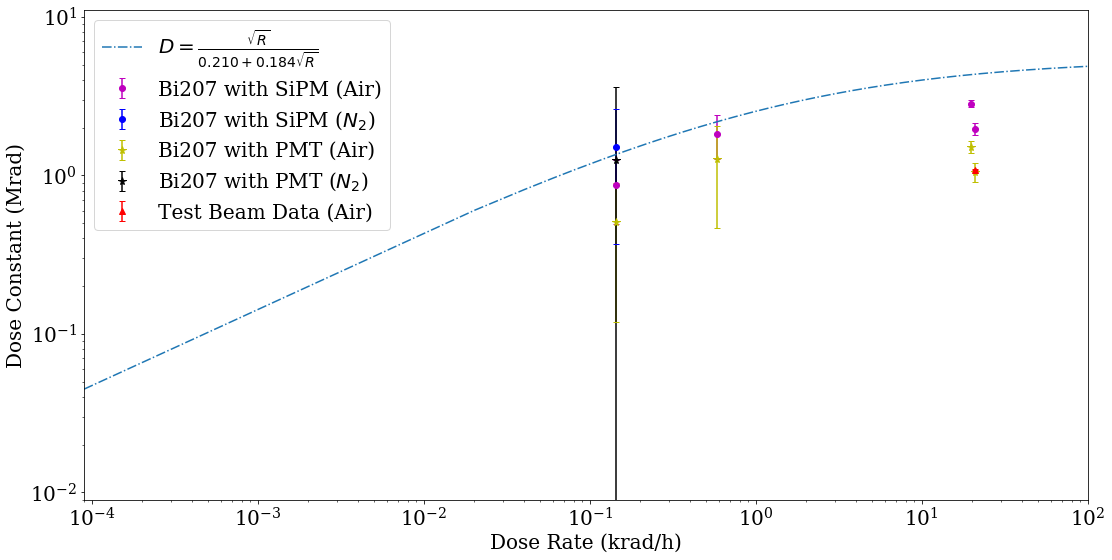

In [254]:
ran = np.linspace(0.00009,101.,5000)
mpl.rc("font", family="serif", size=20)
plt.figure(figsize=(18,9))
plt.yscale("log")
plt.xscale("log")
plt.ylabel("Dose Constant (Mrad)")
plt.xlabel("Dose Rate (krad/h)")
plt.ylim([0.009,11.])
plt.xlim([0.00009,101.])
plt.errorbar(SA_doserate, SA_Dconstant, yerr=SA_error, linestyle='None', fmt='mo', ecolor='m',
             markersize=6, capsize=3) # SiPM Air
plt.errorbar(SN_144[1], SN_144[0], yerr=SN_144[2], linestyle='None', fmt='bo', ecolor='b',
             markersize=6, capsize=3) # SiPM N2
plt.errorbar(PA_doserate, PA_Dconstant, yerr=PA_error, linestyle='None', fmt='y*', ecolor='y',
             markersize=8, capsize=3) # PMT Air
plt.errorbar(PN_144[1], PN_144[0], yerr=PN_144[2], linestyle='None', fmt='k*', ecolor='k',
             markersize=8, capsize=3) # PMT N2
plt.errorbar(TA_208[1], TA_208[0], yerr=TA_208[2], linestyle='None', fmt='r^', ecolor='r',
             markersize=6, capsize=3) # PMT N2
plt.plot(ran, np.sqrt(ran)/(0.210 + 0.184*np.sqrt(ran)), '-.')
plt.legend(["$D = \\frac{\sqrt{R}}{0.210+0.184\sqrt{R}}$","Bi207 with SiPM (Air)","Bi207 with SiPM ($N_2$)",
            "Bi207 with PMT (Air)","Bi207 with PMT ($N_2$)","Test Beam Data (Air)"])
plt.show()

## D vs. R without Error Bars

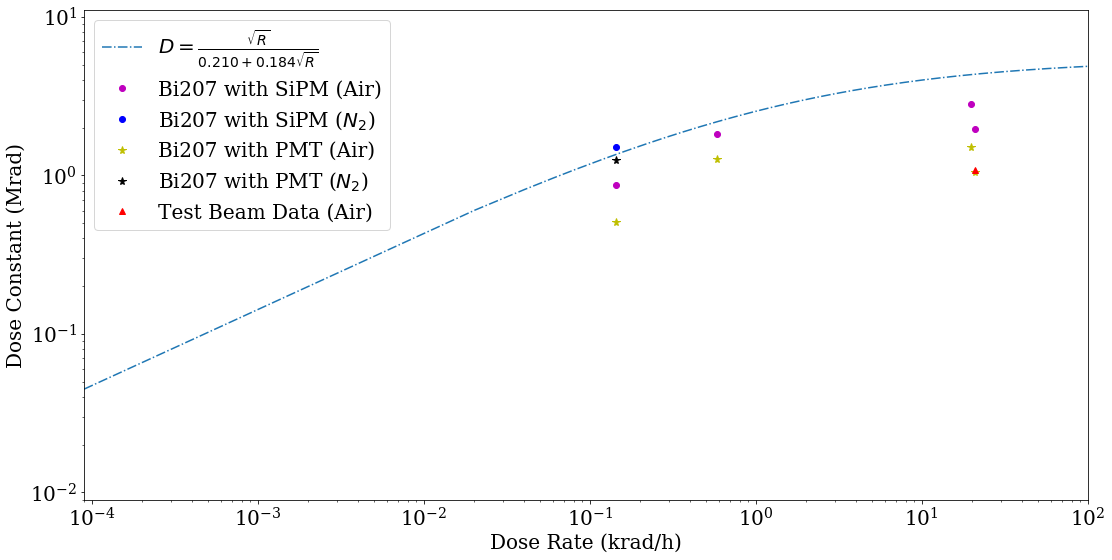

In [253]:
ran = np.linspace(0.00009,101.,5000)
mpl.rc("font", family="serif", size=20)
plt.figure(figsize=(18,9))
plt.yscale("log")
plt.xscale("log")
plt.ylabel("Dose Constant (Mrad)")
plt.xlabel("Dose Rate (krad/h)")
plt.ylim([0.009,11.])
plt.xlim([0.00009,101.])
plt.plot(ran, np.sqrt(ran)/(0.210 + 0.184*np.sqrt(ran)), '-.')
plt.plot(SA_doserate, SA_Dconstant, 'mo') # SiPM Air
plt.plot(SN_144[1], SN_144[0], 'bo') # SiPM N2
plt.plot(PA_doserate, PA_Dconstant, 'y*',markersize=8) # PMT Air
plt.plot(PN_144[1], PN_144[0], 'k*',markersize=8) # PMT N2
plt.plot(TA_208[1], TA_208[0], 'r^',markersize=6) # PMT N2
plt.legend(["$D = \\frac{\sqrt{R}}{0.210+0.184\sqrt{R}}$","Bi207 with SiPM (Air)","Bi207 with SiPM ($N_2$)",
            "Bi207 with PMT (Air)","Bi207 with PMT ($N_2$)","Test Beam Data (Air)"])
plt.show()